In [15]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import random
import sklearn as sklearn
from datetime import datetime
import keras
import seaborn as sns

import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.9.1


<h1> Note

Dataset file needed: diabetes_binary_5050split_health_indicators_BRFSS2015.csv


<h1>Dependencies

Pandas 1.4.3
NumPy 1.22.3
matplotlib 3.5.1
scikit-learn 1.0.2

<h1> Resources used

<a href="https://scikit-learn/stable/modules/classes.html">Sci-Kit Learn</a>
<a href="https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset?select=diabetes_012_health_indicators_BRFSS2015.csv">Dataset</a>
<a href="https://scikit-learn.org/stable/modules/classes.html#hyper-parameter-optimizers">Optimizers</a>
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate"> cross validation </a>
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV">GridSearch </a>
<a href="https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter">Scoring</a>




<h1>Load in the dataset</h1>

In [16]:
#reads the dataset in as a pandas dataframe
with open("diabetes_binary_5050split_health_indicators_BRFSS2015.csv", "r") as read_content:
    file = pd.read_csv(read_content)
# opens a file to store model details for quick reference
with open("analysis.txt", "w+") as analysis:
    analysis.write("Model Name\t| Recall")

if not os.path.exists(".\models"):
    print("Creating models folder")
    os.mkdir(".\models")

<h1> Data information

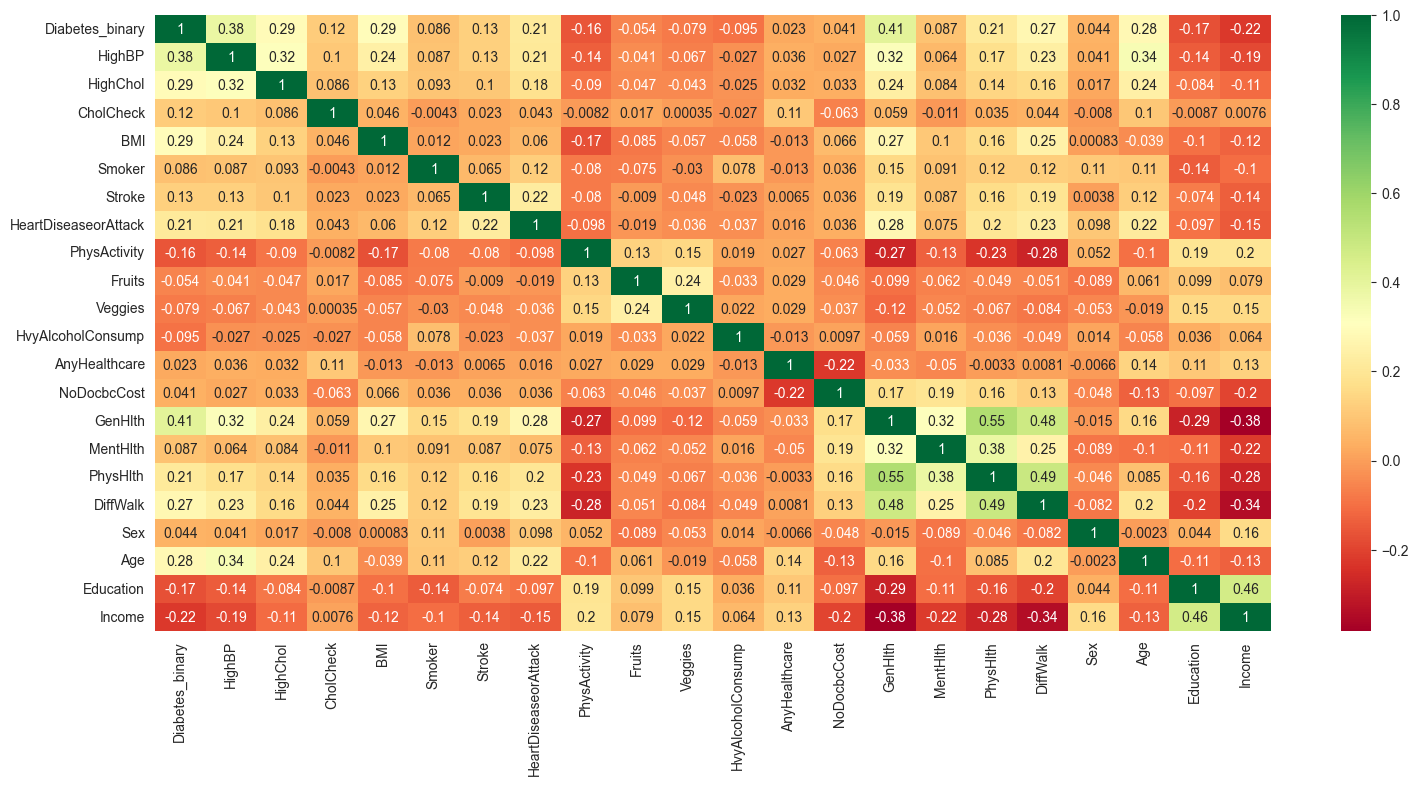

In [17]:

plt.figure(figsize = (18,8))
sns.heatmap(file.corr(),annot=True , cmap ='RdYlGn' );

In [18]:
file.describe().T;

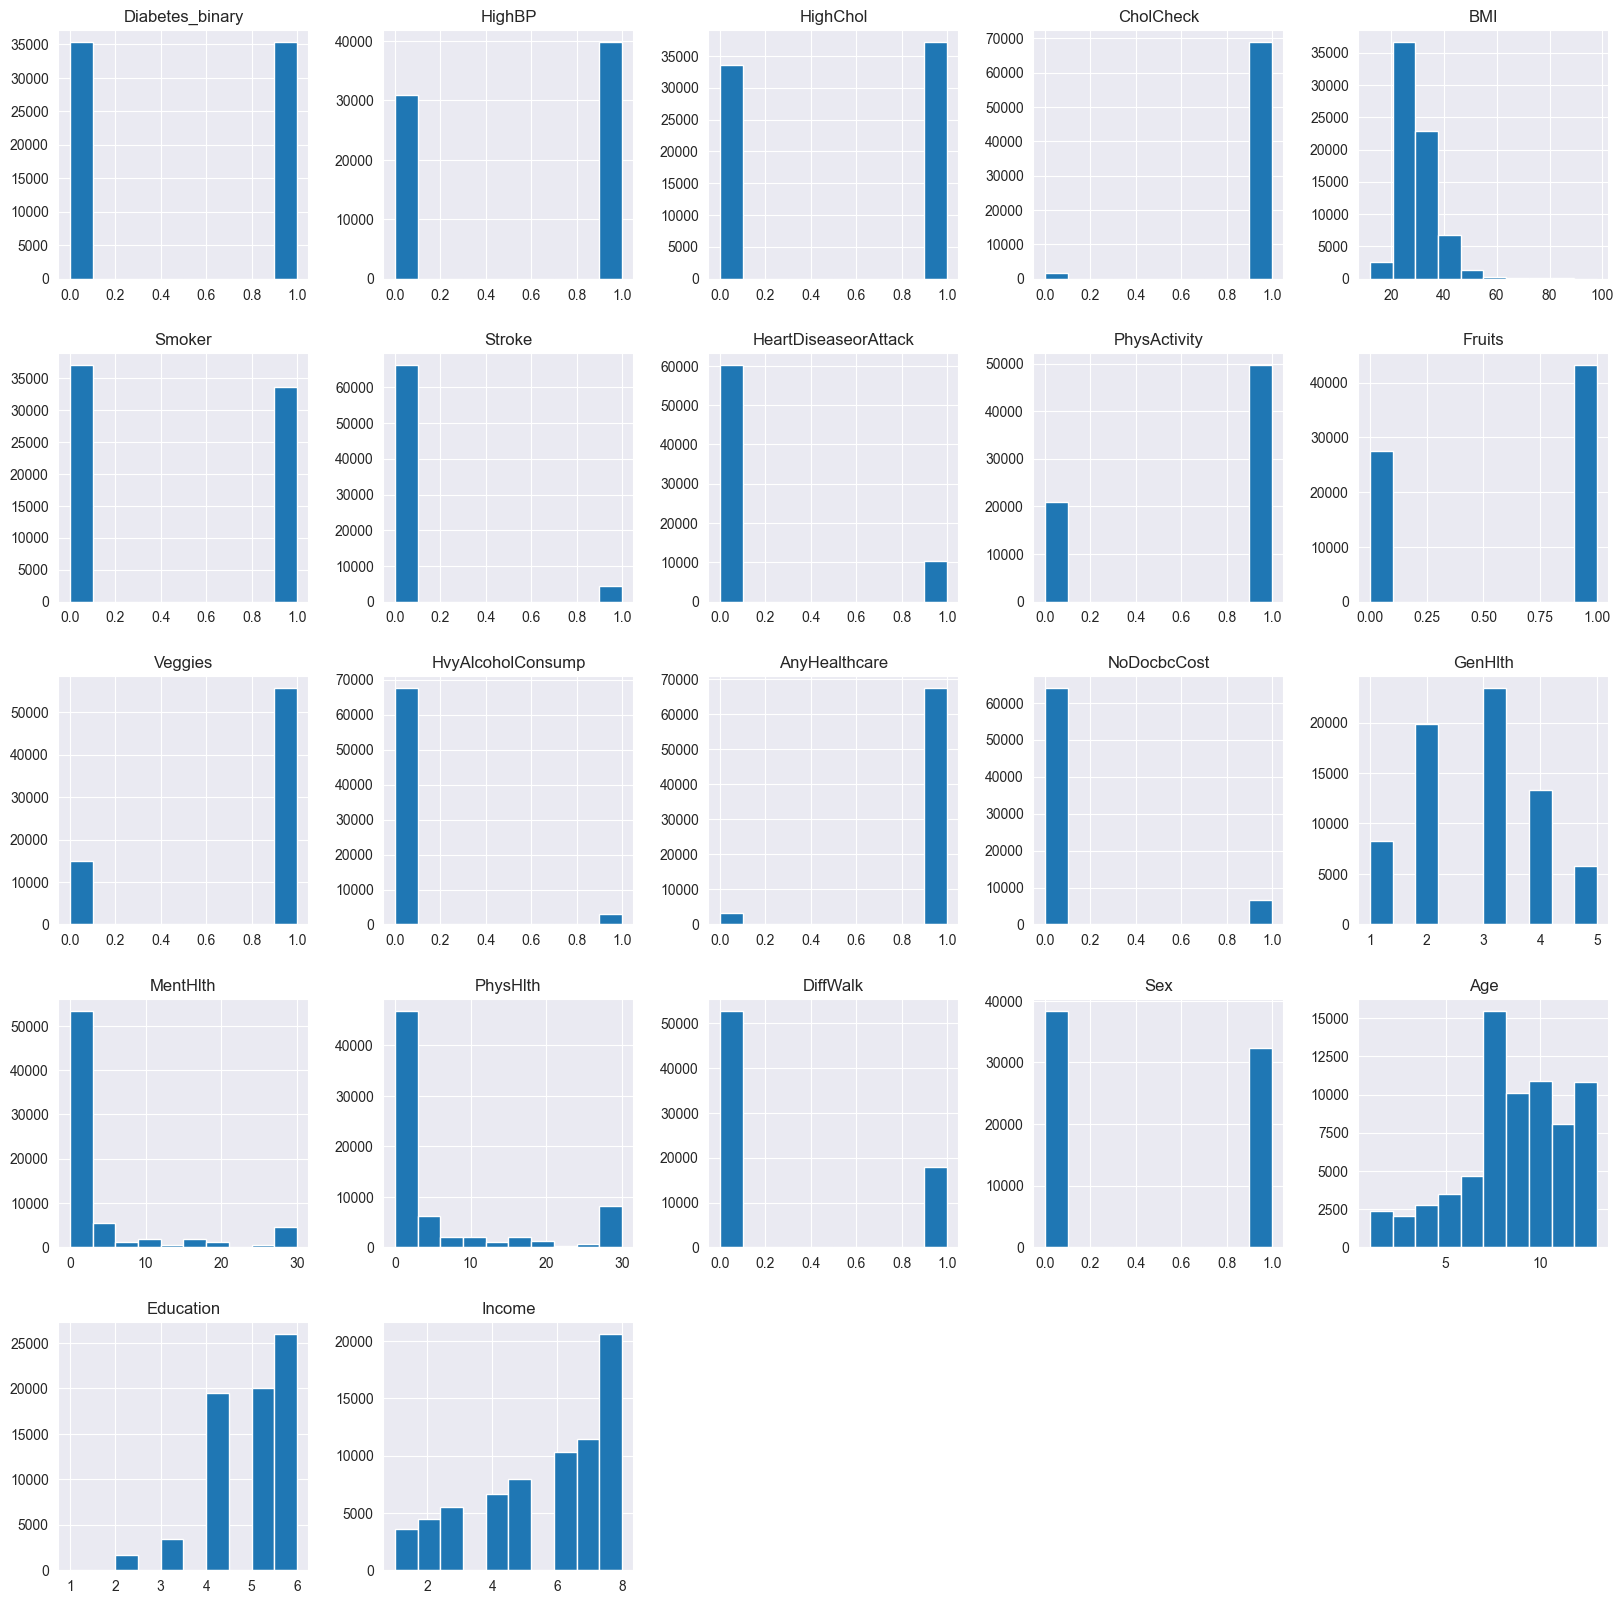

In [19]:
file.hist(figsize=(20,20));

<h1>Dataset Details</h1>

Preprocessing and cleaning of data for Nan values

In [20]:
nan_in_df = file.isnull().values.any()
file.replace([np.inf, -np.inf], np.nan, inplace=True)
file.dropna(inplace=True)

<h1>Data Preparation (Feature and Selection)</h1>

In [21]:
y = file["Diabetes_binary"] #label
X = file.iloc[:,1:len(file.columns)] #features

<h1>Training Test Split</h1>

In [22]:
random.seed(0)
seed  =int(random.random()*100)
print(f"Seed number: "+ str(seed)) #seed number is 84
X_train,X_test,y_train, y_test = train_test_split(X,y, test_size = 0.2, train_size=0.8, shuffle=True, random_state=seed)
scaler = sklearn.preprocessing.StandardScaler()
scaledTrain = scaler.fit_transform(X_train)
scaledTest = scaler.fit_transform(X_test)

Seed number: 84


<h1>Data Splitting Proportions

In [23]:
for i in range(0,2):
    print(f"Training occurences of {i}: {np.count_nonzero(y_train == i)}")
for i in range(0,2):
    print(f"Test occurences of {i}: {np.count_nonzero(y_test == i)}")

Training occurences of 0: 28187
Training occurences of 1: 28366
Test occurences of 0: 7159
Test occurences of 1: 6980


<h1>Metrics Call</h1>

Easy to use method call to provide consistent metric information after prediction

In [24]:
def metrics(model, true_y,prediction_y):
    with open("analysis.txt", "a") as analysis:
        analysis.write(f"\n{model}\t{recall_score(y_true=true_y,y_pred= prediction_y,average='weighted')}")
    print(f"{model}\t| {recall_score(y_true=true_y,y_pred= prediction_y,average='weighted')}")
    print(classification_report(y_true=true_y,y_pred= prediction_y, zero_division=0))
    confusion_matrix(y_true=true_y,y_pred= prediction_y)

<h1> Regular Decision Tree

In [25]:
DT = tree.DecisionTreeClassifier()

skip=False
if(not skip):
    if (os.path.exists('models/DT_regular_model.pickle')):
        pickle_in = open('models/DT_regular_model.pickle','rb')
        clf = pickle.load(pickle_in)
        print("pickle file used")
    else:
        classifier = DT.fit(X_train, y_train)
        with open('models/DT_regular_model.pickle','wb') as f:
            pickle.dump(classifier, f)

        pickle_in = open('models/DT_regular_model.pickle','rb')
        clf = pickle.load(pickle_in)
else:
    print("skipped")



pickle file used


Regular decision tree	| 0.6577551453426692
              precision    recall  f1-score   support

         0.0       0.66      0.66      0.66      7159
         1.0       0.65      0.66      0.65      6980

    accuracy                           0.66     14139
   macro avg       0.66      0.66      0.66     14139
weighted avg       0.66      0.66      0.66     14139



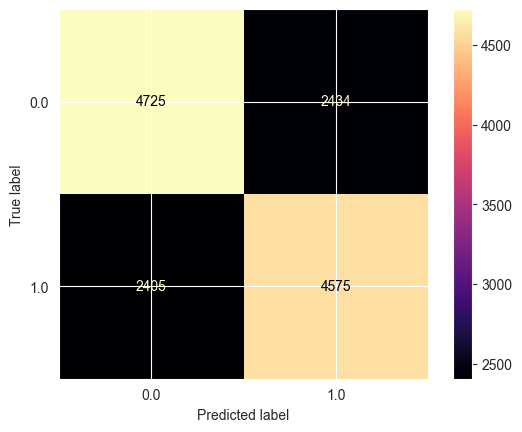

In [26]:
y_predictions_DT = clf.predict(X_test)
metrics("Regular decision tree", y_test, y_predictions_DT)
ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=y_predictions_DT, cmap='magma')

<h1> Randomized search Decision Tree

In [27]:
#add graph that computes cost by max depth
parametersDT = {"criterion":("gini","entropy"),"max_depth":(5,7,10,12,15,18,20,21,25)}
RandomizedDT = RandomizedSearchCV(estimator=clf, scoring="recall", param_distributions=parametersDT)


skip=False
if(not skip):
    if (os.path.exists('models/DTRandomCV_model.pickle')):
        pickle_in = open('models/DTRandomCV_model.pickle','rb')
        clf = pickle.load(pickle_in)
        print("pickle file used")
    else:
        classifier = RandomizedDT.fit(X_train, y_train)
        for i in np.linspace(2,9,8):
            Kvalues=sklearn.model_selection.cross_val_score(clf,X_train,y_train,cv=int(i))
            print("Cross-validation accuracy (" + str(int(i)) + "-fold): " + str(np.mean(Kvalues)*100)+"%")
        with open('models/DTRandomCV_model.pickle','wb') as f:
            pickle.dump(classifier, f)

        pickle_in = open('models/DTRandomCV_model.pickle','rb')
        clf = pickle.load(pickle_in)

else:
    print("skipped")

pickle file used


<h1> Random CV Decision tree with and model report

Randomized CV Decision Tree	| 0.7339274347549332
              precision    recall  f1-score   support

         0.0       0.76      0.70      0.73      7159
         1.0       0.71      0.77      0.74      6980

    accuracy                           0.73     14139
   macro avg       0.74      0.73      0.73     14139
weighted avg       0.74      0.73      0.73     14139



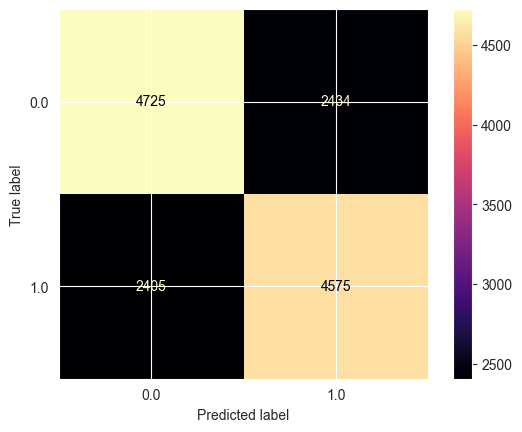

In [28]:
y_predictions_RCV_DT = clf.predict(X_test)
metrics("Randomized CV Decision Tree", y_test, y_predictions_RCV_DT)
ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=y_predictions_DT, cmap='magma')

<h1> Decision tree with scaled data and model report

Decision Tree model with scaled data	| 0.7359077728269326
              precision    recall  f1-score   support

         0.0       0.76      0.70      0.73      7159
         1.0       0.71      0.78      0.74      6980

    accuracy                           0.74     14139
   macro avg       0.74      0.74      0.74     14139
weighted avg       0.74      0.74      0.74     14139



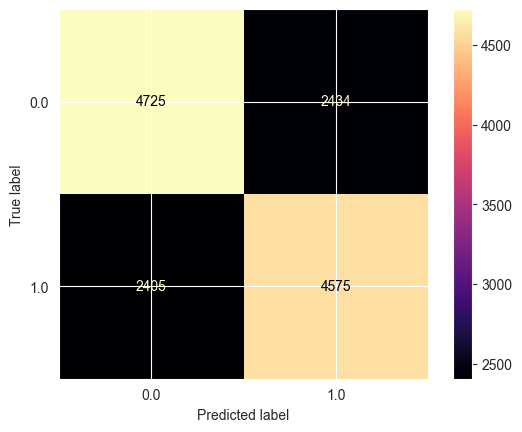

In [29]:
clf.fit(scaledTrain,y_train)
metrics("Decision Tree model with scaled data", y_test, clf.predict(scaledTest))
ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=y_predictions_DT, cmap='magma')

<h1> Random Forest

In [30]:
#add graph that computes cost by depth

parameters = {"criterion":("gini","entropy"),"max_depth":(5,7,10,12,15,18,20,21,25)}
randomForest = RandomForestClassifier(n_jobs=-1)
classifier = RandomizedSearchCV(estimator=randomForest, param_distributions=parameters,n_jobs=1, scoring="recall", verbose=0, refit=True, cv=8)
#helps avoid re-training if a model exists already
if (os.path.exists('models/RandomForest.pickle')):
    pickle_in = open('models/RandomForest.pickle','rb')
    clf = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, y_train)
    with open('models/RandomForest.pickle','wb') as f:
        pickle.dump(classifier, f)
    pickle_in = open('models/RandomForest.pickle','rb')
    clf = pickle.load(pickle_in)

pickle file used


<h1>Model Report for Random Forest</h1>

Best estimator: RandomForestClassifier(criterion='entropy', max_depth=10, n_jobs=-1), Best Score: 0.796516953885146
Random Forest	| 0.7459509159063583
              precision    recall  f1-score   support

         0.0       0.78      0.70      0.74      7159
         1.0       0.72      0.79      0.76      6980

    accuracy                           0.75     14139
   macro avg       0.75      0.75      0.75     14139
weighted avg       0.75      0.75      0.75     14139



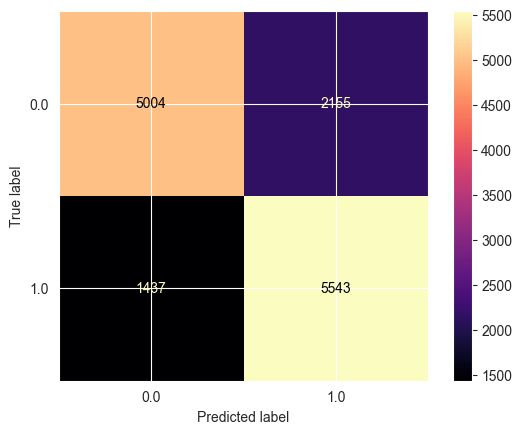

In [31]:
y_sent_predict = clf.best_estimator_.predict(X_test)
print(f"Best estimator: {clf.best_estimator_}, Best Score: {clf.best_score_}")
metrics("Random Forest",y_test,y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=y_sent_predict, cmap='magma')

<h1> Random forest with scaled data and model report

Random forest model with scaled data	| 0.7481434330575005
              precision    recall  f1-score   support

         0.0       0.78      0.70      0.74      7159
         1.0       0.72      0.80      0.76      6980

    accuracy                           0.75     14139
   macro avg       0.75      0.75      0.75     14139
weighted avg       0.75      0.75      0.75     14139



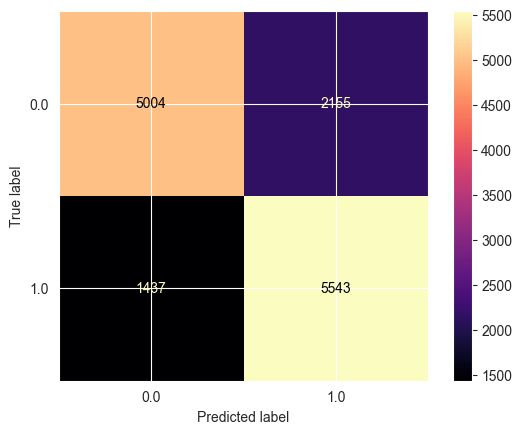

In [32]:
clf.fit(scaledTrain,y_train)
metrics("Random forest model with scaled data", y_test, clf.predict(scaledTest))
ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=y_sent_predict, cmap='magma')

<h1>Multi-Layer Perceptron

In [33]:
parameters = {"activation":("identity", "logistic", "tanh", "relu"),"hidden_layer_sizes":((42,21),(21,42))}

clfMLP = MLPClassifier(verbose=True)
classifier = RandomizedSearchCV(estimator=clfMLP, param_distributions=parameters,n_jobs=-1, refit=True, scoring="recall")
skip=False
if(not skip):
    if (os.path.exists('models/MLPRandomCV_model.pickle')):
        pickle_in = open('models/MLPRandomCV_model.pickle','rb')
        clf = pickle.load(pickle_in)
        print("pickle file used")
    else:
        classifier = classifier.fit(X_train, y_train)
        with open('models/MLPRandomCV_model.pickle','wb') as f:
            pickle.dump(classifier, f)

        pickle_in = open('models/MLPRandomCV_model.pickle','rb')
        clf = pickle.load(pickle_in)

else:
    print("skipped")

pickle file used


<h1>Model Report for Multi-Layer Perceptron using Random Search</h1>

Best estimator: MLPClassifier(hidden_layer_sizes=(42, 21), verbose=True), Best Score: 0.8159432025037932
MLP Random Search	| 0.7446778414315015
              precision    recall  f1-score   support

         0.0       0.75      0.73      0.74      7159
         1.0       0.73      0.76      0.74      6980

    accuracy                           0.74     14139
   macro avg       0.74      0.74      0.74     14139
weighted avg       0.74      0.74      0.74     14139



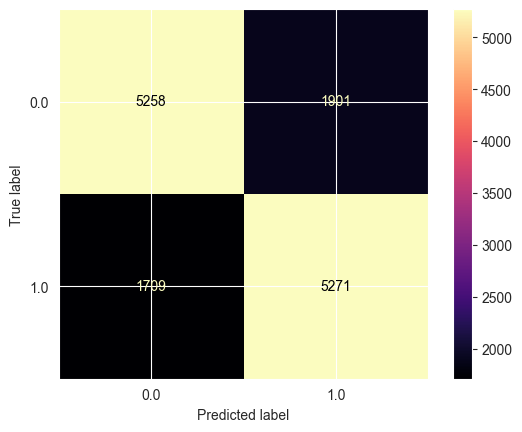

In [34]:
y_sent_predict = clf.best_estimator_.predict(X_test)
print(f"Best estimator: {clf.best_estimator_}, Best Score: {clf.best_score_}")
metrics("MLP Random Search",y_test,y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=y_sent_predict, cmap='magma')

<h1> Multi-Layer Perceptron with scaled data

C:\Users\chanj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Iteration 1, loss = 0.58566194
Iteration 2, loss = 0.51262847
Iteration 3, loss = 0.50917758
Iteration 4, loss = 0.50825179
Iteration 5, loss = 0.50795229
Iteration 6, loss = 0.50752088
Iteration 7, loss = 0.50720988
Iteration 8, loss = 0.50678407
Iteration 9, loss = 0.50650016
Iteration 10, loss = 0.50612124
Iteration 11, loss = 0.50565284
Iteration 12, loss = 0.50522260
Iteration 13, loss = 0.50465067
Iteration 14, loss = 0.50420671
Iteration 15, loss = 0.50358813
Iteration 16, loss = 0.50337774
Iteration 17, loss = 0.50277482
Iteration 18, loss = 0.50209693
Iteration 19, loss = 0.50177946
Iteration 20, loss = 0.50157950
Iteration 21, loss = 0.50131842
Iteration 22, loss = 0.50097355
Iteration 23, loss = 0.50086700
Iteration 24, loss = 0.50070393
Iteration 25, loss = 0.50039669
Iteration 26, loss = 0.50015665
Iteration 27, loss = 0.50012121
Iteration 28, loss = 0.49992936
Iteration 29, loss = 0.49984310
Iteration 30, loss = 0.49969756
Iteration 31, loss = 0.49948178
Iteration 32, los

C:\Users\chanj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


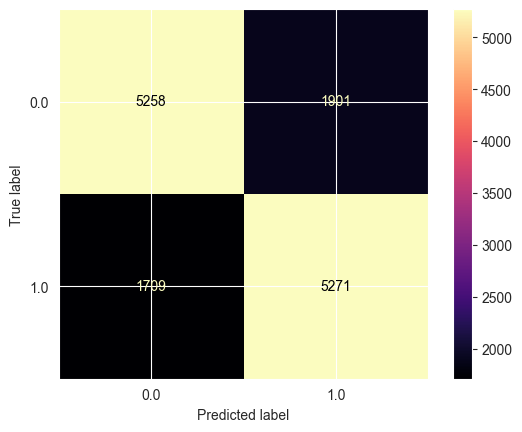

In [35]:
clf.fit(scaledTrain,y_train)
metrics("MLP model with scaled data", y_test, clf.predict(scaledTest))
ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=y_sent_predict, cmap='magma')

<h1> Logistic regression using Random Search


In [36]:
logisticclassifier = sklearn.linear_model.LogisticRegression()

param_distribution = {'penalty':np.array(['l1','l2']),'C':np.array([1,10,100,1000])}

randomsearch = sklearn.model_selection.RandomizedSearchCV(logisticclassifier,param_distribution,random_state=0, verbose=1,n_iter=32,cv=4 )

skip=False
if(not skip):
    if (os.path.exists('models/LogisticRegressionRandomSearch_model.pickle')):
        pickle_in = open('models/LogisticRegressionRandomSearch_model.pickle','rb')
        clf = pickle.load(pickle_in)
        print("pickle file used")
    else:
        classifier = randomsearch.fit(X_train,y_train)
        with open('models/LogisticRegressionRandomSearch_model.pickle','wb') as f:
            pickle.dump(classifier, f)

        pickle_in = open('models/LogisticRegressionRandomSearch_model.pickle','rb')
        clf = pickle.load(pickle_in)

else:
    print("skipped")

pickle file used


<h1>Model Report for Logistic Regression using Random Search </h1>


Logistic model with random search	| 0.7377466581795035
              precision    recall  f1-score   support

         0.0       0.75      0.72      0.74      7159
         1.0       0.72      0.76      0.74      6980

    accuracy                           0.74     14139
   macro avg       0.74      0.74      0.74     14139
weighted avg       0.74      0.74      0.74     14139



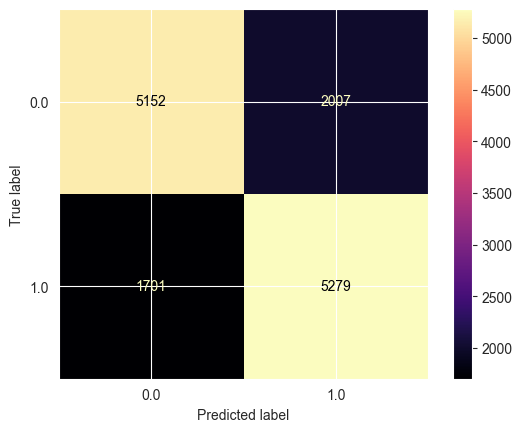

In [37]:
y_predictions_Logistic = clf.predict(X_test)
metrics("Logistic model with random search", y_test, clf.best_estimator_.predict(X_test))
ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=y_predictions_Logistic, cmap='magma')

<h1> Logistic regression with scaled data


C:\Users\chanj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 8 is smaller than n_iter=32. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 4 folds for each of 8 candidates, totalling 32 fits
Logistic model with scaled data	| 0.7442534832732159
              precision    recall  f1-score   support

         0.0       0.76      0.72      0.74      7159
         1.0       0.73      0.77      0.75      6980

    accuracy                           0.74     14139
   macro avg       0.74      0.74      0.74     14139
weighted avg       0.75      0.74      0.74     14139



C:\Users\chanj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
16 fits failed out of a total of 32.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\chanj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\chanj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\chanj\AppData\Local\Programs\Pyth

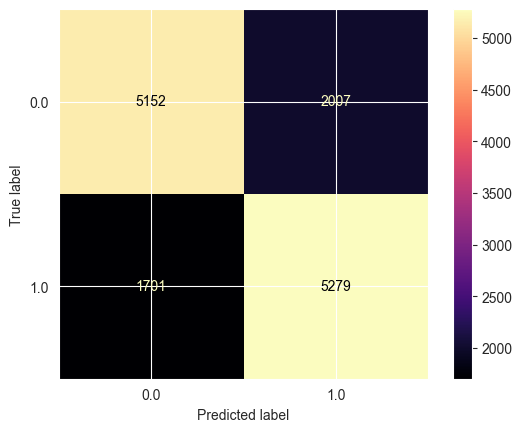

In [38]:
clf.fit(scaledTrain,y_train)
metrics("Logistic model with scaled data", y_test, clf.predict(scaledTest))
ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=y_predictions_Logistic, cmap='magma')

<h1> Neural Network

In [39]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(21,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='sigmoid'),
    tf.keras.layers.Softmax()
])
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [40]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2816      
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
 softmax (Softmax)           (None, 2)                 0         
                                                                 
Total params: 3,074
Trainable params: 3,074
Non-trainable params: 0
_________________________________________________________________


In [44]:
skip=False
if(not skip):
    if (os.path.exists('models/NeuralNetwork')):
        clf = tf.keras.models.load_model('models/NeuralNetwork')
        print("pickle file used")
    else:
        classifier = model.fit(X_train, y_train, epochs=10, verbose=1)
        model.save('models/NeuralNetwork')

        clf = tf.keras.models.load_model('models/NeuralNetwork')

else:
    print("skipped")

pickle file used


Neural Network	| 0.5061885564749983
              precision    recall  f1-score   support

         0.0       0.51      0.95      0.66      7159
         1.0       0.50      0.05      0.09      6980

    accuracy                           0.51     14139
   macro avg       0.50      0.50      0.38     14139
weighted avg       0.50      0.51      0.38     14139



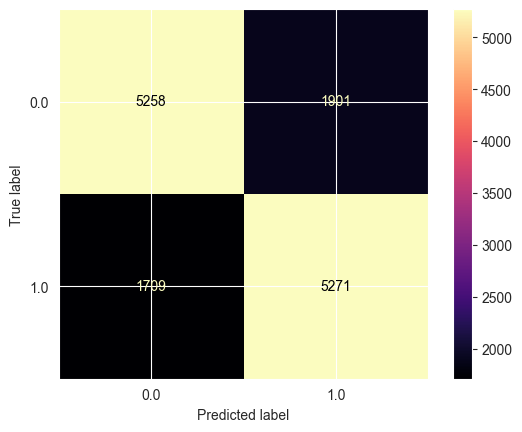

In [45]:
y_pred = model.predict_on_batch(X_test)
y_pred_clean = []

for decision in range(len(y_pred)):
    if y_pred[decision][0] < y_pred[decision][1]:
        y_pred_clean.append(1)
    else:
        y_pred_clean.append(0)

metrics("Neural Network", y_test,y_pred_clean)
ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=y_sent_predict, cmap='magma')